# Lyrics Trends Analysis on Billboard


** Team member : Shiyao Li, Yongfa Tan, Boyu Liu **

## Introduction
In this project, we are going to investigate the music trends of the Billboard Hot-100 charts from 1950 to 2017. 
Since 1958, the Hot-100 chart has been accepted as the 'gold standard' or benchmark of the popular music rankings.
During the recent half a century, the lyric style in the U.S. has kept changing over the years. 

Specifically, we looked at the differences among different attributes of words like POS of tag and sentiment etc. for each decade.

Overall, five main parts are included in our project:
1. Data collection & preprocessing
2. Lyrics Words Analysis
3. Sentimental Analysis
4. K-means Clustering & Visualization

First things first, we have directly use another complete crawler notebook to do the data collection job. Please refer to our prepared notebook [billboard_hot100_crawler.ipynb](https://github.com/KuroLight/Billboard-Trends/blob/master/notebooks/billboard_hot100_crawler.ipynb)


In [6]:
import os
import pandas as pd
import json,string
import nltk, copy
import textblob
import matplotlib.pyplot as plt
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.tag import pos_tag
import matplotlib.pyplot as plt
import os
import copy
import re
import sklearn
#import wordcloud
%matplotlib inline

## Read dataset
Our dataset consists of 60 years billboard records. The first step is to read all the data (.json file) with a single directory and convert them into pandas dataframes. As we can see, there are 232489 songs in this dataset, which really takes a long time to load them and do the following dataframe-related operations in the following part.

In [2]:
import json
from pprint import pprint

path = "Billboard-Trends/lyrics_50_18/"
# print(cwd)
frames = []
for file in os.listdir('Billboard-Trends/lyrics_50_18/'):
    date = file.split('.')[0].split('_')[-1]
    with open(path + file,'r') as f:
        df = pd.DataFrame(json.load(f)).dropna()
        df['time'] = pd.Timestamp(date)
        frames.append(df)
raw_data = pd.concat(frames).reset_index()  #.drop_duplicates(['artist', 'title']) 

## Data preprocessing
1. str to lower
2. remove stop words
3. remove non-lyric content (eg: [Chorus: David McRae])
4. remove punctuations

In [2]:
import copy
billboard = copy.deepcopy(raw_data)
stop = stopwords.words('english')

def preprocess(lyric):
    lyric = lyric.lower()
    lyric = re.sub(r'\[.*?\]', '', lyric)  # remove [*] pattern
    lyric = lyric.replace("'s",'')
    lyric = lyric.replace("'ve",'')
    lyric = lyric.replace("'",'')    # ' must be ignored
    lyric = lyric.replace("-",' ')
    
    translator = str.maketrans(string.punctuation,' '*len(string.punctuation))
    lyric = lyric.translate(translator)
    tokens = nltk.word_tokenize(lyric)
    
    return tokens

stop = set(stop)
billboard['lyrics'] = billboard['lyrics'].apply(lambda x: preprocess(x))
billboard['lyrics'] = billboard['lyrics'].apply(lambda x:[w for w in x if w not in stop])
billboard.head(10)

## Several Features to Analyze in Lyrics
Our goal is to analyze the lyrics by year, and find trends from different angles. 


First, the vocabulary of lyrics is a representation of how many unique words are used in a song. The more varied the vocabulary, the higher the song's lexical diversity. We find that the total amount of words per year is increasing over the years according to the graph. 

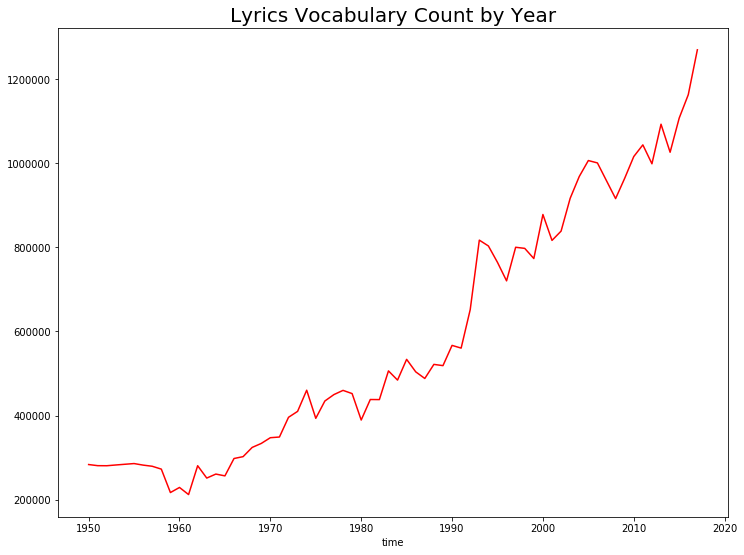

In [4]:

billboard['vocab_cnt'] = billboard['lyrics'].str.len()
total_year_cnt = billboard.groupby(billboard.time.dt.year)['vocab_cnt'].sum()
plt.figure(figsize=(12, 9))
plt.title("Lyrics Vocabulary Count by Year", fontsize=20)
total_year_cnt.plot(kind='line', color='Red')

Second, we have studied the total count of nouns and adjectives in songs.
The total amount of nouns is increasing just like the trend of words count but
adjectives count which usually represents emotion is not increasing that much. This may be because lyrics of top songs become longer so the total amount of nouns also grows over the years.

In [5]:
def get_NN_pos_tag(lyric):
    return len([w for w, pos in pos_tag(lyric) if pos == 'NN'])

billboard['nouns_cnt'] = billboard['lyrics'].apply(lambda x: get_NN_pos_tag(x))
billboard.head(10)

,index,artist,lyrics,time,title,vocab_cnt,nouns_cnt
0,0,Ricky Nelson,"[used, play, around, hearts, hastened, call, m...",1950-01-07,Poor Little Fool,158,49
1,2,Bobby Darin,"[splish, splash, taking, bath, long, saturday,...",1950-01-07,Splish Splash,118,32
2,3,Elvis Presley With The Jordanaires,"[well, hard, headed, woman, soft, hearted, man...",1950-01-07,Hard Headed Woman,133,54
3,5,Duane Eddy His Twangy Guitar And The Rebels,[],1950-01-07,Rebel-'rouser,0,0
4,6,The Coasters,"[take, papers, trash, dont, get, spendin, cash...",1950-01-07,Yakety Yak,95,56
5,12,Patti Page,"[hi, lee, hi, lo, hi, lup, hi, lee, hi, lo, hi...",1950-01-07,Left Right Out Of Your Heart (Hi Lee Hi Lo Hi ...,182,67
6,13,Pat Boone,"[oh, darling, oh, lover, dreams, came, true, d...",1950-01-07,If Dreams Came True,73,19
7,14,Jerry Butler and The Impressions,"[precious, love, means, love, could, ever, wan...",1950-01-07,For Your Precious Love,66,22
8,15,The Danleers,"[one, summer, night, fell, love, one, summer, ...",1950-01-07,One Summer Night,55,23
9,16,Jody Reynolds,"[verse, 1, night, black, rain, falling, looked...",1950-01-07,Endless Sleep,85,27


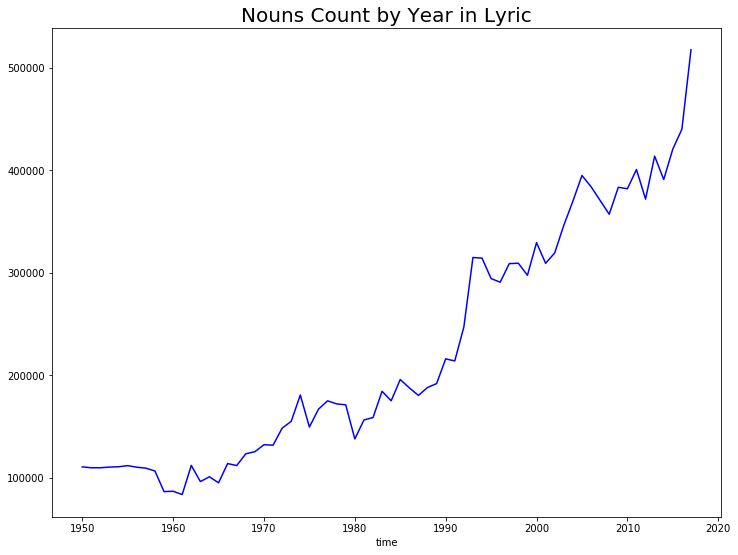

In [6]:
nouns_cnt = billboard.groupby(billboard.time.dt.year)['nouns_cnt'].sum()
plt.figure(figsize=(12, 9))
plt.title("Nouns Count by Year in Lyric", fontsize=20)
nouns_cnt.plot(kind='line', color='Blue')

In [7]:
def get_Adj_pos_tag(lyric):
    return len([w for w, pos in pos_tag(lyric) if pos == 'JJR'])

billboard['adjs_cnt'] = billboard['lyrics'].apply(lambda x: get_Adj_pos_tag(x))
billboard.head(10)

,index,artist,lyrics,time,title,vocab_cnt,nouns_cnt,adjs_cnt
0,0,Ricky Nelson,"[used, play, around, hearts, hastened, call, m...",1950-01-07,Poor Little Fool,158,49,0
1,2,Bobby Darin,"[splish, splash, taking, bath, long, saturday,...",1950-01-07,Splish Splash,118,32,0
2,3,Elvis Presley With The Jordanaires,"[well, hard, headed, woman, soft, hearted, man...",1950-01-07,Hard Headed Woman,133,54,0
3,5,Duane Eddy His Twangy Guitar And The Rebels,[],1950-01-07,Rebel-'rouser,0,0,0
4,6,The Coasters,"[take, papers, trash, dont, get, spendin, cash...",1950-01-07,Yakety Yak,95,56,1
5,12,Patti Page,"[hi, lee, hi, lo, hi, lup, hi, lee, hi, lo, hi...",1950-01-07,Left Right Out Of Your Heart (Hi Lee Hi Lo Hi ...,182,67,0
6,13,Pat Boone,"[oh, darling, oh, lover, dreams, came, true, d...",1950-01-07,If Dreams Came True,73,19,0
7,14,Jerry Butler and The Impressions,"[precious, love, means, love, could, ever, wan...",1950-01-07,For Your Precious Love,66,22,0
8,15,The Danleers,"[one, summer, night, fell, love, one, summer, ...",1950-01-07,One Summer Night,55,23,0
9,16,Jody Reynolds,"[verse, 1, night, black, rain, falling, looked...",1950-01-07,Endless Sleep,85,27,0


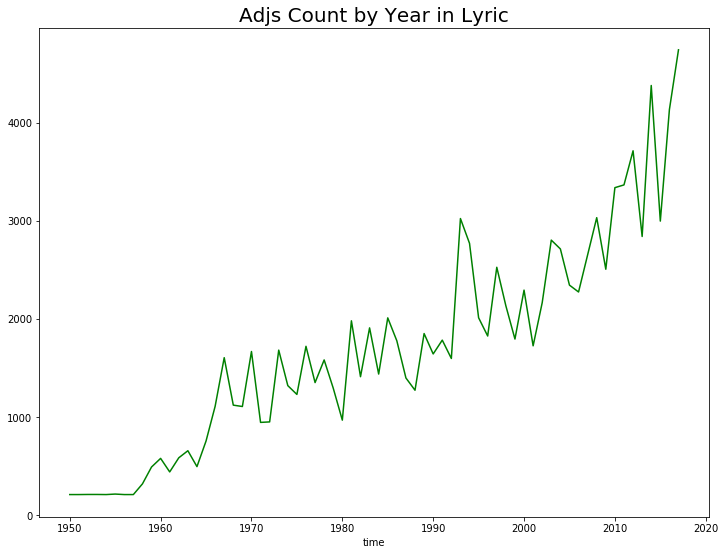

In [8]:
adjs_cnt = billboard.groupby(billboard.time.dt.year)['adjs_cnt'].sum()
plt.figure(figsize=(12, 9))
plt.title("Adjs Count by Year in Lyric", fontsize=20)
adjs_cnt.plot(kind='line', color='Green')

Third, we analyze the data trends about the artists. As we can see from the graph, Elvis ranked the top as for the number of songs while Eminem ranked the top as for the vocabulary count. Therefore, Elvis can be treated as the evergreen tree on Billboard. Eminem, as we all know, is a rap singer and the length of rap lyrics is usually larger than the other one.

In [9]:
artist_cnt = billboard.artist.value_counts()[:25]
artist_cnt

Elvis Presley With The Jordanaires    1270
The Everly Brothers                   1114
Chuck Berry                           1021
Pat Boone                              996
Bobby Freeman                          918
Taylor Swift                           710
Connie Francis                         701
Madonna                                699
Sam Cooke                              697
Elton John                             688
Bobby Darin                            669
Fats Domino                            624
Tim McGraw                             618
Ricky Nelson                           589
Marty Robbins                          584
Nat King Cole                          583
Stevie Wonder                          583
Dean Martin                            568
Michael Jackson                        564
Whitney Houston                        547
The Beatles                            531
Billy Joel                             531
Tony Bennett                           530
Drake      

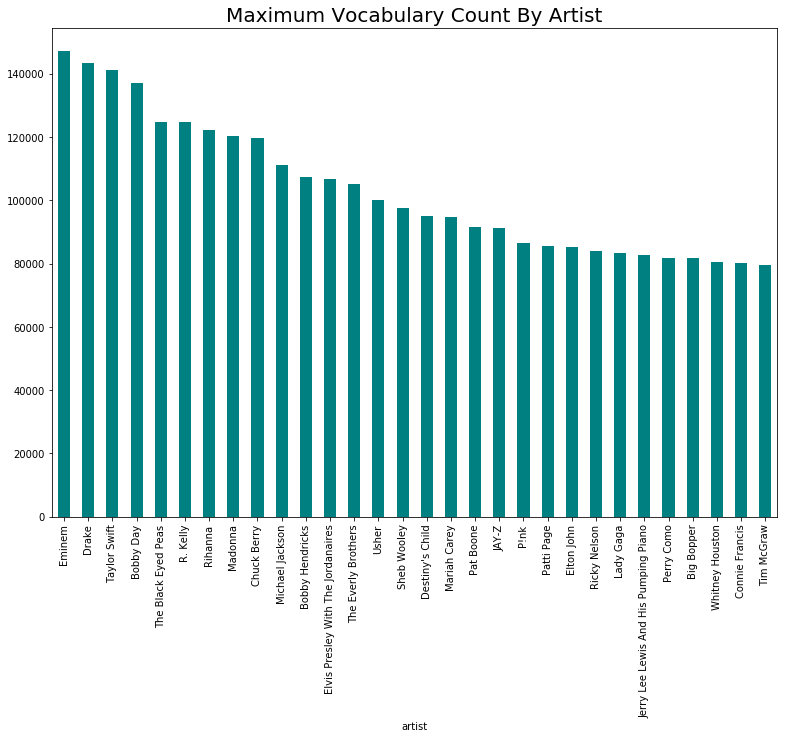

In [10]:
plt.figure(figsize=(13,9))
plt.title("Maximum Vocabulary Count By Artist",fontsize=20)
vocab_cnt_by_artist = billboard.groupby('artist').agg({'vocab_cnt': sum}) \
                        .sort_values(['vocab_cnt'], ascending=False).vocab_cnt[:30]
vocab_cnt_by_artist.plot('bar',color='teal')

# Sentimental analysis on BillBoard Trends

In this part we tries to uncover what the songs tries to convey by analyzing the lyrics of each song from 1950 to 2018. We have delve deeper into text mining by unnesting lyrics into tokenized words for lyrical complexity. The results shows us critical insights for the next steps of sentimental analysis and topic modeling.

In [3]:
# parse json to dataframe
import os
import pandas as pd
import json,string
import nltk, copy
import textblob
import maplotlib.pyplot as plt
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.tag import pos_tag
import matplotlib.pyplot as plt
import multiprocessing
import os
import copy
import re
import sklearn
import seaborn as sns
from collections import Counter
#import wordcloud
%matplotlib inline
from subprocess import check_output

First we import the Billboad Trends lyrics from the folder.

In [37]:
path = "Billboard-Trends/lyrics_50_18/"
frames = []
for filename in os.listdir(path):
    date = filename.split(".")[0].split("_")[-1]
    if not filename.endswith(".json"): # encoding error because .DS_store exists
        continue
    with open(path + filename, encoding="utf-8") as f:
        df = pd.DataFrame(json.load(f)).dropna()
        df["Date"] = pd.Timestamp(date)
    frames.append(df)
billboard = pd.concat(frames)

In [38]:
backup = copy.deepcopy(billboard)

Then we clean the data by use the following techniques:
    1. stemming the lyircs
    2. remove the stopwords and punctuations
    3. normalize by lowering the words in the lyrics

In [39]:
def process(text, lemmatizer=nltk.stem.wordnet.WordNetLemmatizer()):
    stopwords = nltk.corpus.stopwords.words('english')
    musicwords = set(["intro", "verse"])

    text = text.lower()
    text = text.replace("'s", "")
    text = text.replace("'","")
    exclude = set(string.punctuation)
    for punc in exclude:
        text = text.replace(punc , " ")
    tokens = nltk.word_tokenize(text)
    sentence = []
    for word in tokens:
        word_stem = str(lemmatizer.lemmatize(word))
        if word_stem not in stopwords and word_stem not in musicwords:
            sentence.append(word_stem)
    return sentence

def process_all(df, lemmatizer=nltk.stem.wordnet.WordNetLemmatizer()):
    df['lyrics'] = df['lyrics'].apply(lambda x: " ".join(process(x)))
    return df

def sentiment_label(polarity):
    # positive 
    if polarity > 0.1:
        return "positive"
    # negtive
    elif polarity < -0.1:
        return "negative"
    # netrual
    else:
        return "netural"

In [40]:
# clean the data 1) normalize, 2).stemming 3).remove the stop words + laji words
billboard["artist"] = billboard["artist"].apply(lambda x : x.lower())
billboard["title"] = billboard["title"].apply(lambda x : x.lower())
billboard = process_all(billboard)

In this part, we explore a simple implementation of the NLP technique known as sentiment analysis, which attempts to quantify the tonal properties of a text dataset. This is done using the TextBlob library, and is applied to the 'A Million News Headlines' dataset – a corpus of over one million news article headlines published by the ABC.

We now run the TextBlob sentiment function on every lyrics, and use it to construct a new series for both subjectivity and polarity.


In [5]:
# draw the textBob graph
billboard["TextBlob"] = billboard["lyrics"].apply(lambda x : textblob.TextBlob(str(x)))
billboard["polarity"] = billboard["TextBlob"].apply(lambda x: x.sentiment.polarity)
billboard["subjectivity"] = billboard["TextBlob"].apply(lambda x: x.sentiment.subjectivity)

In [42]:
billboard["sentiment"] = billboard["polarity"].apply(lambda x: sentiment_label(x))

In [43]:
df = billboard

In [44]:
df = df.set_index(pd.DatetimeIndex(df['Date']))
monthly_averages =  df.resample('M').mean()
yearly_averages =  df.resample('A').mean()

Text(0.5,1,'Mean Polarity Score')

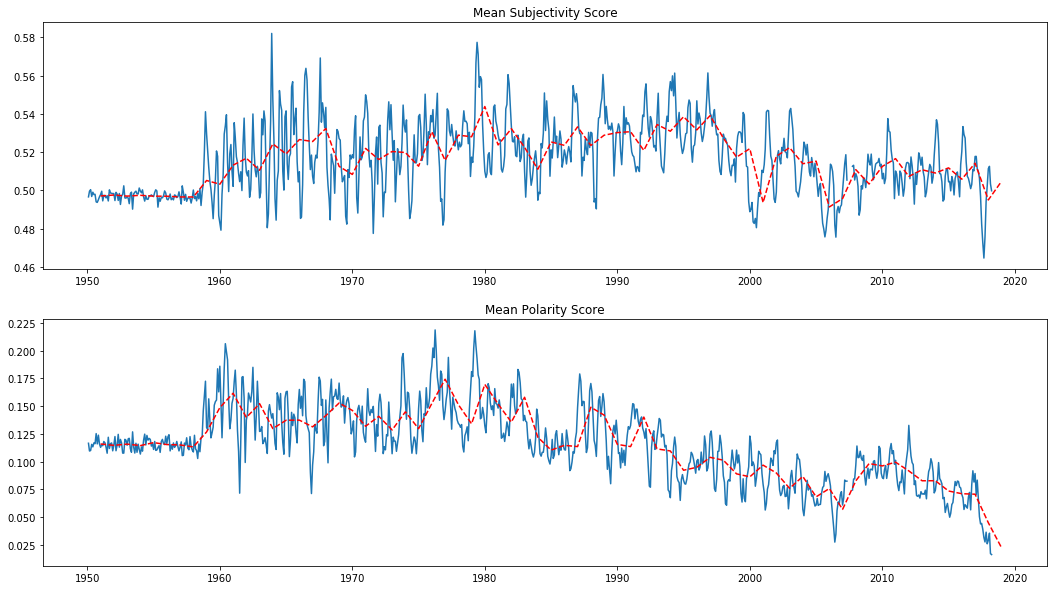

In [45]:
fig, ax = plt.subplots(2, figsize=(18,10))
ax[0].plot(monthly_averages['subjectivity'])
ax[0].plot(yearly_averages['subjectivity'], 'r--')
ax[0].set_title('Mean Subjectivity Score')
ax[1].plot(monthly_averages['polarity'])
ax[1].plot(yearly_averages['polarity'], 'r--')
ax[1].set_title('Mean Polarity Score')

Evidently there have been distinct changes in the recent 70 years

In the 1960~1980 people are more subjective and positive, and in recent years people seems less positive and more objective, this is partly in the influence of the economy.



In [46]:
# positive and negative percent
year_filter = billboard.Date.dt.to_period("A")
df2 = billboard[["artist","sentiment"]].groupby([year_filter,"sentiment"]).count()
df2.rename(columns={"artist":'count'}, inplace=True)
df3 = df2.unstack(level=-1).reset_index()
df3.columns.values

In [8]:
df3.columns = [''.join(str(col).strip()).strip() for col in df3.columns.values]
df3.rename(columns={"('Date', '')" :'Date',
                    "('count', 'positive')":"positive",
                    "('count', 'netural')":"neutral",
                    "('count', 'negative')":"negative"}, inplace=True)
df3.head()

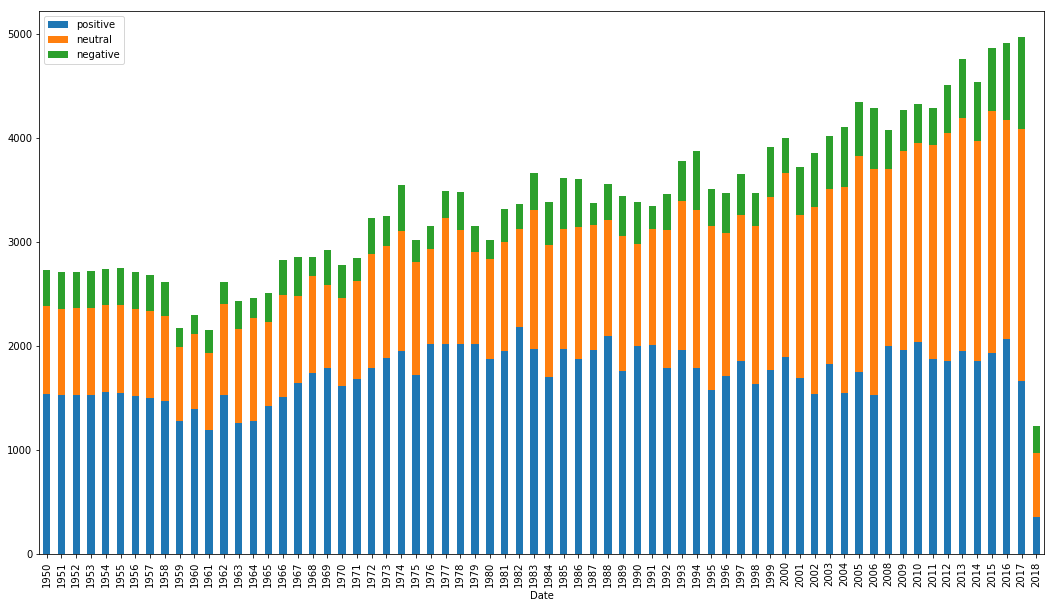

In [78]:
df3[["Date","positive","neutral","negative"]].plot(kind='bar', stacked=True, figsize = (18,10))

We dive into the portion of sentiment, we can see that people tends to be more neutral.

Nowadays, we can say that the young people are pursuing a buddha-like life, in Chinese it's 佛系青年.

## K-means Clustering
We use a clustering algorithm to better understand the hidden structure within the lyrics with a TF-IDF matrix. Here we choose K-Means with a predetermined number 8 of clusters. Each observation is assigned to a cluster so that it can minimize the within cluster sum of squares.

In [11]:
stopwords = set(nltk.corpus.stopwords.words('english'))
# load nltk's SnowballStemmer as variabled 'stemmer'
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

In [24]:
def load_df_from_json():
    cwd = os.getcwd()
    frames = []
    path = 'Billboard-Trends/lyrics_08_18/'
    for file in os.listdir(path):
        date = file.split('.')[0].split('_')[-1]
        with open(path + file, 'r') as f:
            df = pd.DataFrame(json.load(f)).dropna()
            df['time'] = pd.Timestamp(date)
            frames.append(df)
    raw_data = pd.concat(frames)
    return raw_data.drop_duplicates(['title','artist']).reset_index() 

In [25]:
def preprocess(lyric):
    lyric = lyric.lower()
    lyric = re.sub(r'\[.*?\]', '', lyric)  # remove [*] pattern
    lyric = lyric.replace("'s", '')
    lyric = lyric.replace("'ve", '')
    lyric = lyric.replace("'", '')  # ' must be ignored
    lyric = lyric.replace("-", ' ')

    translator = str.maketrans(string.punctuation, ' ' * len(string.punctuation))
    lyric = lyric.translate(translator)
#     tokens = nltk.word_tokenize(lyric)

    return lyric #[w for w in tokens if w not in stopwords]

def words2sentence(words):
    return ' '.join(words)

In [26]:
def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

In [27]:
raw_data = load_df_from_json()
billboard = copy.deepcopy(raw_data)

In [9]:
totalvocab_stemmed = []
totalvocab_tokenized = []
for i in billboard['lyrics']:
    allwords_stemmed = tokenize_and_stem(i) #for each item in 'synopses', tokenize/stem
    totalvocab_stemmed.extend(allwords_stemmed) #extend the 'totalvocab_stemmed' list
    
    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)

#print(billboard.head(20))

In [29]:
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)
print('there are ' + str(vocab_frame.shape[0]) + ' items in vocab_frame')
print(vocab_frame.head())

there are 1601348 items in vocab_frame
                                           words
intro                                      intro
t-pain                                    t-pain
flo                                          flo
rida                                        rida
hmm-mmm-mmm-mmm-mmm-mmm  hmm-mmm-mmm-mmm-mmm-mmm


In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer

#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_df=0.3, max_features=200000,
                                 min_df=0.1, stop_words='english',
                                 use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,5))

%time tfidf_matrix = tfidf_vectorizer.fit_transform(billboard['lyrics']) #fit the vectorizer to synopses

print(tfidf_matrix.shape)

terms = tfidf_vectorizer.get_feature_names()
print(terms)

Wall time: 33.7 s
(3540, 132)
["'d", 'alon', 'alway', 'anoth', 'ask', 'ass', 'away', 'bad', 'beat', 'befor', 'believ', 'best', 'better', 'big', 'bitch', 'bodi', 'bout', 'boy', 'break', 'bring', 'came', 'car', 'care', 'chang', 'close', 'crazi', 'damn', 'danc', 'day', 'did', 'die', 'door', 'dream', 'drink', 'drop', 'em', 'end', 'everi', 'everybodi', 'everyth', 'eye', 'face', 'fall', 'feel like', 'fli', 'friend', 'fuck', 'game', 'god', 'gon na', 'gone', 'good', 'got ta', 'hand', 'hard', 'hate', 'head', 'hear', 'heart', 'hey', 'high', 'hit', 'hold', 'home', 'hook', 'hope', "i'm", 'kiss', 'leav', 'left', "let 's", 'lie', 'life', 'light', 'littl', 'live', 'long', 'lose', 'man', 'mean', 'mind', 'money', "n't know", 'new', 'nigga', 'night', 'noth', 'old', 'onli', 'peopl', 'place', 'play', 'pre-chorus', 'pull', 'real', 'realli', 'ride', 'roll', 'run', 'said', 'shit', 'someth', 'song', 'stand', 'start', 'stay', 'stop', 'ta', 'talk', 'thing', 'thought', 'til', 'told', 'tonight', 'tri', 'tryna', '

In [31]:
from sklearn.cluster import KMeans

num_clusters = 8
km = KMeans(n_clusters=num_clusters)

%time km.fit(tfidf_matrix)

clusters = km.labels_.tolist()
billboard['clusters'] = clusters
billboard['clusters'].value_counts() #number of films per cluster (clusters from 0 to 4)

Wall time: 13.5 s


3    1631
2     487
5     476
1     377
4     197
0     144
6     118
7     110
Name: clusters, dtype: int64

In [8]:
frame = billboard.set_index(billboard['clusters'])
# del test['index']
frame.head()

In [33]:
print("Top terms per cluster:")
print()
#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

for i in range(num_clusters):
    print("Cluster %d words:" % i, end='')
    
    for ind in order_centroids[i, :6]: #replace 6 with n words per cluster
        #print(ind)
        #print(vocab_frame.ix[terms[ind].split(' ')].values.tolist()[0][0])
        #print(' %s' % vocab_frame.ix[terms[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore'), end=',')
        print(' %s' % vocab_frame.ix[terms[ind].split(' ')].values.tolist()[0][0], end=',')

    print() #add whitespace
    print() #add whitespace
    
#     print("Cluster %d titles:" % i, end='')
   
#     for title in frame.ix[i]['title'].values.tolist():
#         print(' %s,' % title, end='')

    print() #add whitespace
    print() #add whitespace
    
print()
print()

Top terms per cluster:

Cluster 0 words: wo,

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  del sys.path[0]


 wo, fall, heart, stay, hold,



Cluster 1 words: got, ta, ya, hook, boy, 'em,



Cluster 2 words: little, good, night, dance, tonight, let,



Cluster 3 words: heart, life, days, pre-chorus, 'd, away,



Cluster 4 words: gon, night, leave, tonight, pre-chorus, hold,



Cluster 5 words: niggas, bitch, fuck, shit, money, hook,



Cluster 6 words: hey, hook, ya, man, niggas, good,



Cluster 7 words: yeah, said, hook, bitch, life, niggas,







[Multidimensional scaling (MDS)](https://en.wikipedia.org/wiki/Multidimensional_scaling) is a form of non-linear dimensionality reduction. We use MDS to convert our matrix into 2D matrix.  One alternative is PCA(principal component analysis).

In [36]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)

import os  # for os.path.basename

import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.manifold import MDS

MDS()

mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]
print()
print()

Finally, we plot our lyrics clustering using matplotlib.

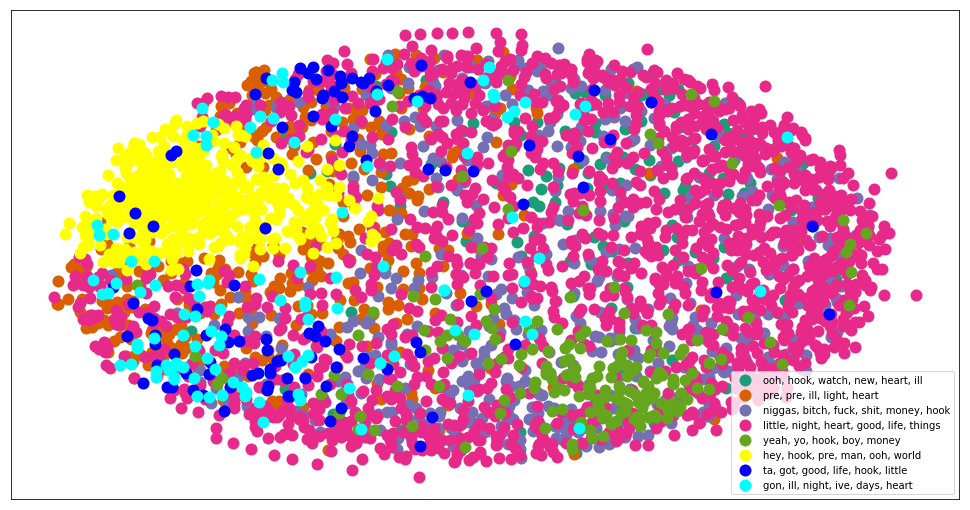

In [37]:
#set up colors per clusters using a dict
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e',5: "#FFFF00", 6: "#0000FF", 7: "#00FFFF"}

#set up cluster names using a dict
cluster_names = {0: 'ooh, hook, watch, new, heart, ill', 
                 1: 'pre, pre, ill, light, heart', 
                 2: 'niggas, bitch, fuck, shit, money, hook', 
                 3: 'little, night, heart, good, life, things', 
                 4: 'yeah, yo, hook, boy, money',
                 5: 'hey, hook, pre, man, ooh, world', 
                 6:'ta, got, good, life, hook, little', 
                 7:'gon, ill, night, ive, days, heart'}

#some ipython magic to show the matplotlib plots inline
%matplotlib inline 

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters)) 

#group by cluster
groups = df.groupby('label')


# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    print()
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point    
plt.show() #show the plot

Until now we have been abloe to cluster and plot all the lyrics using K-Means. We can see that in the plot we have cluster 8 classes of lyrics. At the same time the majority of all the data were the yellow, pink and green ones. Specifically, 
1. the pink one stands for 'little, night, heart, good, life, things', the genre could be the pop music, since it has words "heart, night, life" which most describes a story.
2. the yellow one means 'hey, man, pre, ooh, world': the genre could be hip hop music, because it has interjection "pre, ooh, hey" words.  
3. the green one could be interpreted as "yeah, yo, boy, money, hook" the genre could be the funk music. 

# Reference
1. https://www.kaggle.com/rahulvks/nlp-billboard-nb-1
2. https://www.datacamp.com/community/tutorials/R-nlp-machine-learning
3. https://www.kaggle.com/devisangeetha/sing-a-song-lyrics-is-here/notebook
4. https://github.com/rasbt/musicmood
5. http://brandonrose.org/clustering#K-means-clustering
6. https://pudding.cool/2017/05/song-repetition/
7. https://www.kaggle.com/rcushen/a-basic-implementation-of-sentiment-analysis